In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os
import glob as glob

In [3]:
from yahoo_fin.stock_info import get_data
import os
from datetime import datetime, timedelta

# Get user input for ticker and intervals
ticker = input("Enter the ticker symbol: ")
interval = input("Enter the interval (e.g., 1m, 1d, 1wk, 1mo): ")

# Get start date
start_option = input("Enter the start date (YYYY-MM-DD) or a range (e.g., 1m, 3m, 1y, etc.) \n-1m interval is limited to 7d \n-1d need to have atleast 3 months of range: ")

future_step_input = int(input("Enter how many days into the future to predict (**Note**: the further into the furture the less accurate)"))

# Convert range to a date
if start_option.endswith('m'):
    months = int(start_option[:-1])
    start_date = (datetime.today() - timedelta(days=30*months)).strftime('%Y-%m-%d')
elif start_option.endswith('y'):
    years = int(start_option[:-1])
    start_date = (datetime.today() - timedelta(days=365.25*years)).strftime('%Y-%m-%d')
else:
    start_date = start_option

# Get end date
end_date = input("Enter the end date (YYYY-MM-DD) or 'tdy' for today: ")
if end_date == 'tdy':
    end_date = datetime.today().strftime('%Y-%m-%d')

# Fetch the data from Yahoo Finance
data = get_data(ticker, start_date=start_date, end_date=end_date, index_as_date=True, interval=interval)

# Drop the 'ticker' column if it exists
if 'ticker' in data.columns:
    data = data.drop(columns=['ticker'])

# Specify the directory where you want to save the file
directory = "../data/"  # replace with your desired path
filename = os.path.join(directory, f"{ticker}_{interval}_{start_date}_to_{end_date}.csv")



# Save the dataframe to a csv file
data.to_csv(filename)

print(f"Data saved to: {filename}")


Data saved to: ../data/msft_1d_2023-07-26_to_2023-10-24.csv


In [4]:
files = [filename]
dataframes = {}

# Read the CSV and set the first column (index) as 'date'
dataframes[ticker] = df = pd.read_csv(files[0], index_col=0)
df.index.name = 'date'

print(dataframes)
# Check the first few rows of the first dataframe to confirm loading
print(dataframes[ticker].head())


{'msft':                   open        high         low       close    adjclose  \
date                                                                     
2023-07-26  341.440002  344.670013  333.109985  337.769989  337.056366   
2023-07-27  340.480011  341.329987  329.049988  330.720001  330.021271   
2023-07-28  333.670013  340.010010  333.170013  338.369995  337.655090   
2023-07-31  336.920013  337.700012  333.359985  335.920013  335.210297   
2023-08-01  335.190002  338.540009  333.700012  336.339996  335.629395   
...                ...         ...         ...         ...         ...   
2023-10-17  329.589996  333.459991  327.410004  332.059998  332.059998   
2023-10-18  332.489990  335.589996  328.299988  330.109985  330.109985   
2023-10-19  332.149994  336.880005  330.910004  331.320007  331.320007   
2023-10-20  331.720001  331.920013  325.450012  326.670013  326.670013   
2023-10-23  325.470001  332.730011  324.390015  329.320007  329.320007   

              volume  
date 

In [5]:
# Data Splitting, training:testing=70:30
train_data = {}
test_data = {}

trainPercentage = 0.8
testPercentage = 1-trainPercentage

# Ensure conversion to numpy array during scaling
scalers = {index: MinMaxScaler(feature_range=(0, 1)) for index in dataframes.keys()}
scaled_data = {index: scalers[index].fit_transform(df[['close', 'open', 'high', 'low', 'adjclose', 'volume']]) for index, df in dataframes.items()}

train_data = {index: data[:int(trainPercentage*len(data))] for index, data in scaled_data.items()}
test_data = {index: data[int(trainPercentage*len(data)):] for index, data in scaled_data.items()}

# Check lengths of train and test data for the first index
for key in dataframes:
    print("Length of train data:", len(train_data[key]))
    print("Length of test data:", len(test_data[key]))


Length of train data: 50
Length of test data: 13


In [6]:
sequence_length = 20

def create_multifeature_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length, 0])  # Predicting the next 'Close' value
    return np.array(x), np.array(y)

# Update the data creation step
scaled_data_multifeature = {index: scalers[index].fit_transform(df[['close', 'open', 'high', 'low', 'adjclose', 'volume']]) for index, df in dataframes.items()}
x_data_multifeature = {index: create_multifeature_sequences(data, sequence_length)[0] for index, data in scaled_data_multifeature.items()}
y_data_multifeature = {index: create_multifeature_sequences(data, sequence_length)[1] for index, data in scaled_data_multifeature.items()}


In [7]:
def create_multifeature_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 6)))  # 6 features now
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

models_multifeature = {index: create_multifeature_model() for index in dataframes.keys()}


In [8]:
epochs = 250

for index, model in models_multifeature.items():
    print(f'Training model: {index}')
    model.fit(x_data_multifeature[index], y_data_multifeature[index], batch_size=64, epochs=epochs)
    print('Done')




Training model: msft
Epoch 1/250


1/1 [==============================] - 3s 3s/step - loss: 0.3501
Epoch 2/250
1/1 [==============================] - 0s 13ms/step - loss: 0.1847
Epoch 3/250
1/1 [==============================] - 0s 12ms/step - loss: 0.1024
Epoch 4/250
1/1 [==============================] - 0s 12ms/step - loss: 0.0906
Epoch 5/250
1/1 [==============================] - 0s 13ms/step - loss: 0.1184
Epoch 6/250
1/1 [==============================] - 0s 13ms/step - loss: 0.1339
Epoch 7/250
1/1 [==============================] - 0s 15ms/step - loss: 0.1253
Epoch 8/250
1/1 [==============================] - 0s 19ms/step - loss: 0.1065
Epoch 9/250
1/1 [==============================] - 0s 14ms/step - loss: 0.0895
Epoch 10/250
1/1 [==============================] - 0s 13ms/step - loss: 0.0793
Epoch 11/250
1/1 [==============================] - 0s 13ms/step - loss: 0.0758
Epoch 12/250
1/1 [==============================] - 0s 12ms/step - loss: 0.0766
Epoch 13/250
1/1 [==============================] - 0s 13ms/ste

In [9]:
# Predictions
train_predictions_multifeature = {}
test_predictions_multifeature = {}

print(f"Training Percentage: {trainPercentage}")

for index, model in models_multifeature.items():
    print(f"Total length of data for index {index}: {len(x_data_multifeature[index])}")
    train_slice = x_data_multifeature[index][:int(trainPercentage*len(x_data_multifeature[index]))]
    test_slice = x_data_multifeature[index][int(trainPercentage*len(x_data_multifeature[index])):]
    
    print(f"Index: {index}")
    print(f"Length of train slice: {len(train_slice)}")
    print(f"Length of test slice: {len(test_slice)}")

    if len(train_slice) == 0 or len(test_slice) == 0:
        print(f"Skipping prediction for index {index} due to empty slice.")
        continue

    train_preds = model.predict(train_slice)
    test_preds = model.predict(test_slice)
    
    train_predictions_multifeature[index] = train_preds
    test_predictions_multifeature[index] = test_preds


# Calculate MAE and MSE
train_mae_multifeature = [mean_absolute_error(y_data_multifeature[index][:int(trainPercentage*len(y_data_multifeature[index]))], train_predictions_multifeature[index]) for index in y_data_multifeature.keys()]
test_mae_multifeature = [mean_absolute_error(y_data_multifeature[index][int(trainPercentage*len(y_data_multifeature[index])):], test_predictions_multifeature[index]) for index in y_data_multifeature.keys()]

train_mse_multifeature = [mean_squared_error(y_data_multifeature[index][:int(trainPercentage*len(y_data_multifeature[index]))], train_predictions_multifeature[index]) for index in y_data_multifeature.keys()]
test_mse_multifeature = [mean_squared_error(y_data_multifeature[index][int(trainPercentage*len(y_data_multifeature[index])):], test_predictions_multifeature[index]) for index in y_data_multifeature.keys()]

# Print results
print(f'LSTM (Multi-feature) - Training MAE Value: {train_mae_multifeature}')
print(f'LSTM (Multi-feature) - Testing MAE Value: {test_mae_multifeature}')
print(f'LSTM (Multi-feature) - Training MSE Value: {train_mse_multifeature}')
print(f'LSTM (Multi-feature) - Testing MSE Value: {test_mse_multifeature}')


Training Percentage: 0.8
Total length of data for index msft: 43
Index: msft
Length of train slice: 34
Length of test slice: 9
1/1 [==============================] - 0s 16ms/step
LSTM (Multi-feature) - Training MAE Value: [0.09169581086289966]
LSTM (Multi-feature) - Testing MAE Value: [0.06518232819727506]
LSTM (Multi-feature) - Training MSE Value: [0.012098096733041998]
LSTM (Multi-feature) - Testing MSE Value: [0.007583889140493889]


In [10]:
def predict_future(model, last_sequence, future_steps):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(future_steps):
        # Predict the next value
        next_prediction = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
        
        # Append this prediction to our future predictions
        future_predictions.append(next_prediction)
        
        # Prepare the new sequence for the next prediction
        current_sequence = np.roll(current_sequence, shift=-1, axis=0)
        current_sequence[-1, 0] = next_prediction  # We only replace the first feature (Close price) as it's the one we're predicting

    return future_predictions

# For example, predicting 30 days into the future for the first index
index_to_forecast = list(dataframes.keys())[0]
last_sequence = x_data_multifeature[index_to_forecast][-1]
future_steps = future_step_input
future_predictions = predict_future(models_multifeature[index_to_forecast], last_sequence, future_steps)

# If you want to inverse transform the predictions to the original scale
# Create a dummy array for inverse transformation
dummy_array_future = np.zeros((len(future_predictions), 6))
dummy_array_future[:, 0] = future_predictions
reverted_future_predictions = scalers[index_to_forecast].inverse_transform(dummy_array_future)[:, 0]



1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


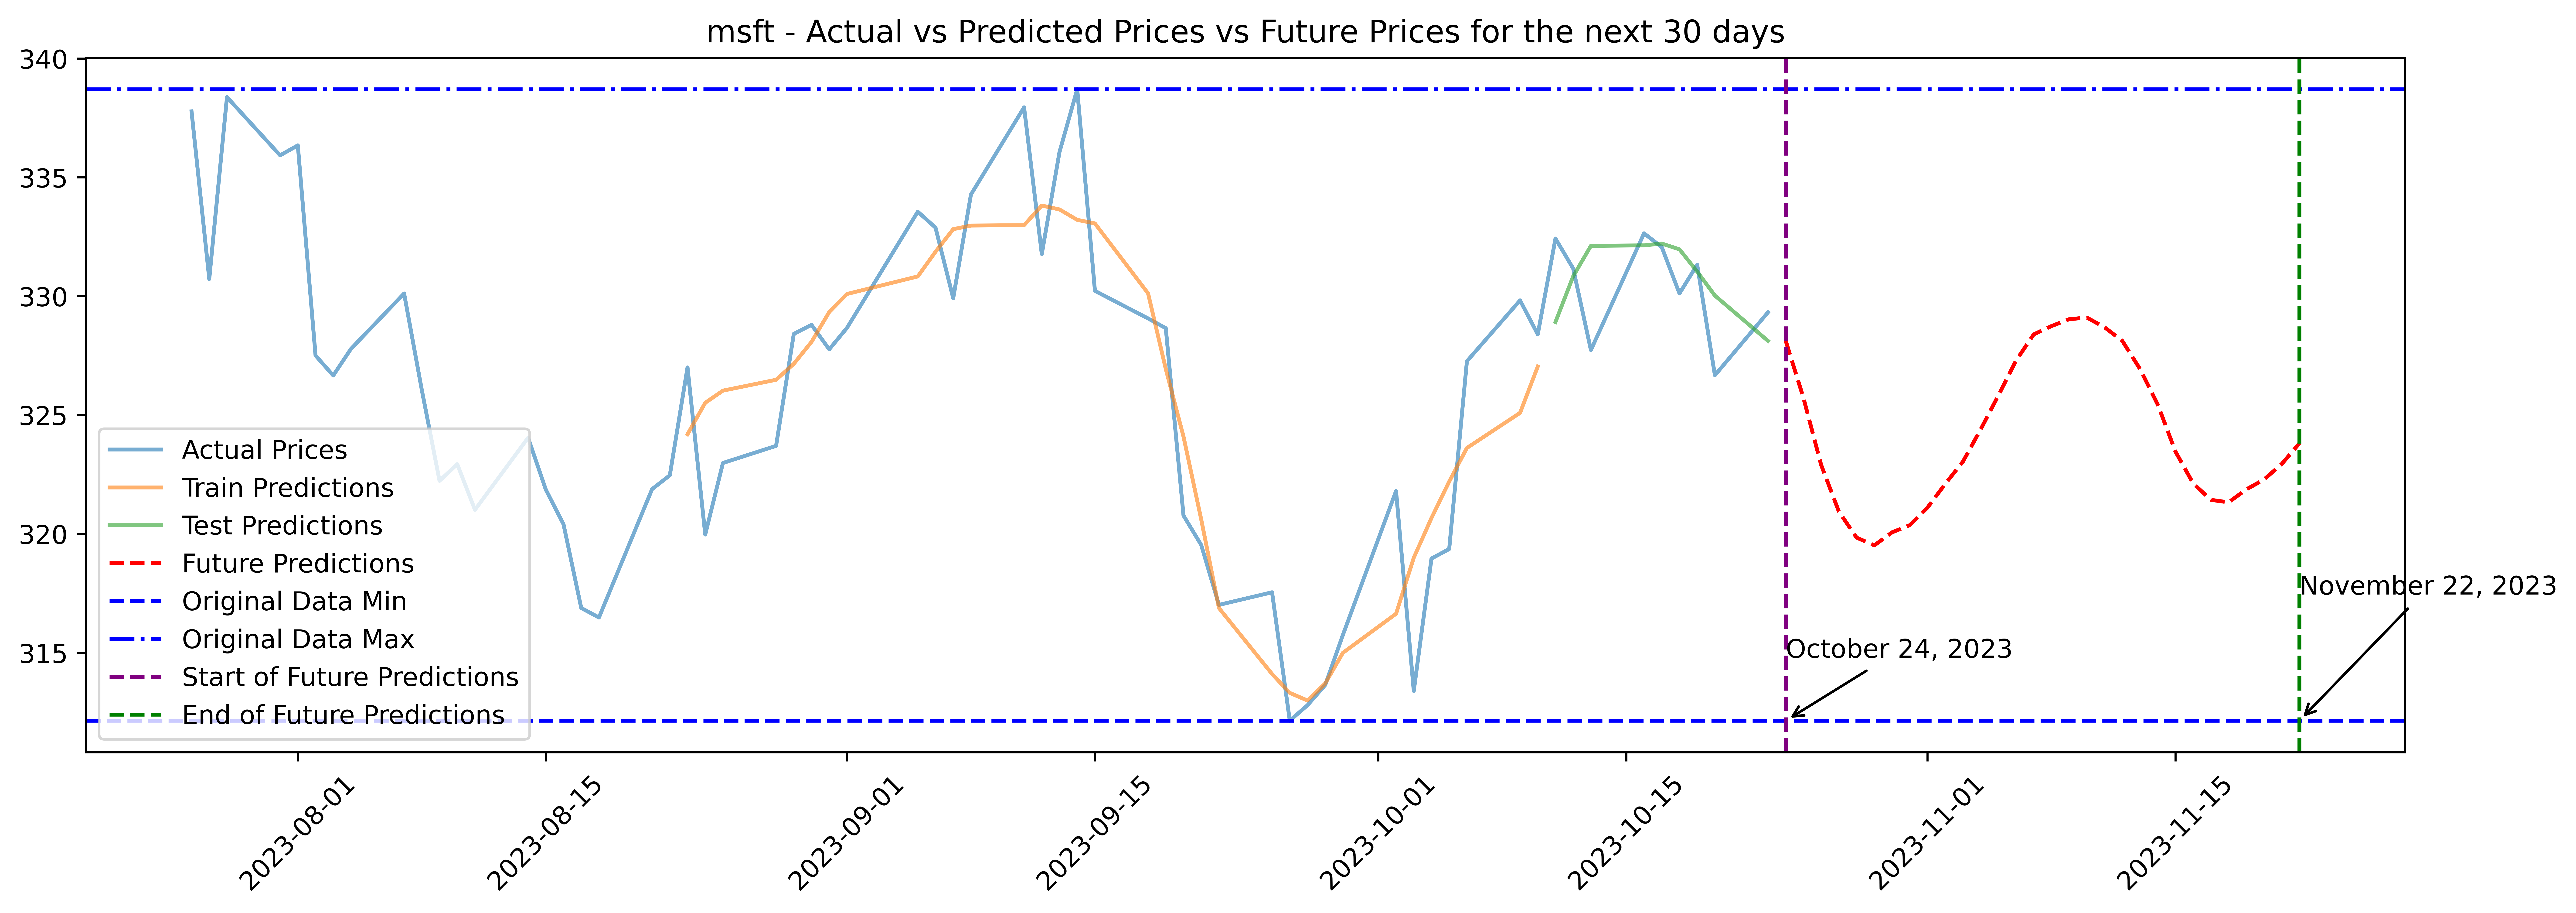

In [15]:
for index, df in dataframes.items():
    plt.figure(figsize=(14, 5), dpi=800)
    
    dates = pd.to_datetime(df.index, dayfirst=True).tz_localize(None)
    df['date'] = dates


    
    # Get the range of the original data for the current index
    original_data_min = df['close'].min()
    original_data_max = df['close'].max()
    
    # Create a dummy array for inverse transformation
    dummy_array_train = np.zeros((train_predictions_multifeature[index].shape[0], 6))
    dummy_array_train[:, 0] = train_predictions_multifeature[index].flatten()
    reverted_train_predictions = scalers[index].inverse_transform(dummy_array_train)[:, 0]
    
    # Repeat for test predictions
    dummy_array_test = np.zeros((test_predictions_multifeature[index].shape[0], 6))
    dummy_array_test[:, 0] = test_predictions_multifeature[index].flatten()
    reverted_test_predictions = scalers[index].inverse_transform(dummy_array_test)[:, 0]
    
    # Plot the actual prices
    plt.plot(dates, df['close'], label='Actual Prices', alpha=0.6)

    #Define Variables
    start_train_pred = sequence_length
    end_train_pred = start_train_pred + len(reverted_train_predictions)

    start_test_pred = end_train_pred
    end_test_pred = start_test_pred + len(reverted_test_predictions)

    
    # Plot the training predictions
    plt.plot(dates[start_train_pred:end_train_pred], reverted_train_predictions, label='Train Predictions', alpha=0.6)
        
    # Plot the testing predictions
    plt.plot(dates[start_test_pred:end_test_pred], reverted_test_predictions, label='Test Predictions', alpha=0.6)

    # Generate future dates for the x-axis (assuming daily frequency; adjust if needed)
    future_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=future_steps).tz_localize(None)

    # Concatenate original dates with the future dates for plotting
    all_dates = pd.concat([pd.Series(dates), pd.Series(future_dates)])


    # Plot the future predictions
    plt.plot(all_dates[-future_steps:], reverted_future_predictions, label='Future Predictions', color='red', linestyle='dashed')
        
    # Add vertical lines indicating the range of original data
    plt.axhline(original_data_min, color='blue', linestyle='--', label='Original Data Min')
    plt.axhline(original_data_max, color='blue', linestyle='-.', label='Original Data Max')


    # Indicate where the future predictions start
    start_future_predictions = len(dataframes[index_to_forecast]['close'])

    # Add a vertical line at the start of the future predictions
    plt.axvline(x=all_dates.iloc[start_future_predictions], color='purple', linestyle='--', label='Start of Future Predictions')

    # Annotate the starting date of the future predictions
    start_date_str = all_dates.iloc[start_future_predictions].strftime('%B %d, %Y')  # Converts date to "Month day, year" format
    plt.annotate(start_date_str, 
                xy=(all_dates.iloc[start_future_predictions], df['close'].min()), 
                xytext=(all_dates.iloc[start_future_predictions], df['close'].min() + (df['close'].max() - df['close'].min()) * 0.1),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                horizontalalignment='left')
    
    # Indicate where the future predictions end
    end_future_predictions = start_future_predictions + future_steps

    # Add a vertical line at the end of the future predictions
    plt.axvline(x=all_dates.iloc[-1], color='green', linestyle='--', label='End of Future Predictions')


    # Annotate the ending date of the future predictions
    end_date_str = all_dates.iloc[-1].strftime('%B %d, %Y')
    plt.annotate(end_date_str, 
                xy=(all_dates.iloc[-1], df['close'].min()), 
                xytext=(all_dates.iloc[-1], df['close'].min() + (df['close'].max() - df['close'].min()) * 0.2),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                horizontalalignment='left')
        
    plt.title(f'{index} - Actual vs Predicted Prices vs Future Prices for the next {future_steps} days')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()
    

files = glob.glob('../data/*')
for f in files:
    os.remove(f)

